# Project 12: Spatial fairness in urban environments 

In [1]:
import geopandas as gpd
import folium
import numpy as np
import networkx as nx 
import pandas as pd
import itertools
import warnings
import sumolib
import os
#import openrouteservice as ors
from sklearn.preprocessing import MinMaxScaler

from shapely.geometry import LineString, Point

import warnings
warnings.filterwarnings("ignore")

from plot_utils import edges_to_gps_list, plot_paths, plot_bar_paths_cost
from routing_utils import from_sumo_to_igraph_network
from routing_algorithms import *
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup

attribute = 'traveltime'

## Utility <br>

In [2]:
# modified version of the function of GiulianoCornacchia from the github,
# the only change is that the returned dataframe has one column for the edge id and one column for the geometry
def gdf_from_sumo_network(sumo_road_network, crs="EPSG:4326", edge_list=None):
    edges_to_plot = sumo_road_network.getEdges()
        
    list_line_strings = []
    list_ids = [] 

    for edge in edges_to_plot: 
        list_ids.append(edge.getID())      
        edge_gps_list = [sumo_road_network.convertXY2LonLat(x[0], x[1]) for x in edge.getShape()]
        list_line_strings.append(LineString(edge_gps_list))

    df_net = gpd.GeoDataFrame(data = list_ids, geometry=list_line_strings, crs="EPSG:4326") 

    df_net.columns = ['id', 'geometry']
    return df_net 

In [4]:
# create a blank map for the city of Leuven
def Leuven_map():
    point = (50.849738563227824, 4.644786576420597)
    m = folium.Map(location=point, zoom_start = 12)
    return m

m = Leuven_map()

## Data Preparation

The first step of the project was the data preparation. <br>
Three datasets:
* The real hub configuration, the locations of all mobility hubs in Leuven where mobility services are clustered together.
* The administrative zones of Leuven, GIS file with the sectors (identified by parameter CODSEC).
* The road network generated with SUMO

For each dataset I kept only the 'important' attributes, generally this means 
geometry, identifier and, in the case of the road network, the edge id.

In [8]:
# Open the hubs dataframe
url = 'https://storageaccount11111111.blob.core.windows.net/container1/Leuven/hub_data_leuven/mobility_hubs.gpkg'
hubs = gpd.read_file('mobility_hubs.gpkg').to_crs('epsg:4326')[['nr', 'naam punt', 'geometry']]
folium.GeoJson(hubs).add_to(m)

In [9]:
# Open the zone dataframe
zones_leuven = gpd.read_file('leuven_statsec.gpkg')
zones_leuven = zones_leuven.to_crs('epsg:4326')[['CODSEC', 'geometry']]

In [10]:
# road network from the sumo network
#
# build the network, the gdf and the graph directly from the sumo configuration
net = sumolib.net.readNet(os.getcwd()+'/Sumo/osm.net.xml')
road_net = gdf_from_sumo_network(net)
G = from_sumo_to_igraph_network(net)

Some operations were performed on the dataframes.<br>

Firstly, for each road in the network, it's useful to have its zone. I performed a spatial join and kept only the streets associated with a zone.<br>
For the purpose of the project, the dimension of the dataset is sufficient as long as the simulations are statistically significant. However, in future versions, one possible alternative is to infer new zones using clustering algorithms, for example, without the need to drop some streets.<br>

Next, it's easier to have only the zones with at least one represented road. This can aid in the random selection of zones, ensuring that regardless of the zone picked, there is always at least one road to serve as the starting/ending point. For this reason, I decided to drop zones without a road from the dataframe.<br>

In the hub dataframe, I chose to perform the spatial join once again to retrieve the zones and add the nearest edge in the SUMO net. This approach allows me to save computation time since the possible starting points are pre-computed and available in the hub dataframe. I set a threshold in the search for the nearest edge, and hubs with no edges within that radius are discarded from the dataset.<br>

Finally, I opted to extract, for each zone, its neighbors. Since one of the tasks is to retrieve the time needed for a user to exit from the neighborhood, having a list of adjacent zones ready for use makes it easier. This allows me to create flows between a zone and one of its neighbors.<br>

In [11]:
# spatial join between road network and the zones
road_net = road_net.sjoin(zones_leuven, how = 'inner')[['id', 'geometry', 'CODSEC']]

In [12]:
# some of the zone may be useless, since they don't 'point' to any street, I decided to drop them
selected_zones = set(road_net['CODSEC'].tolist())
indexs_to_drop = []

for idx, row in zones_leuven.iterrows():
    if row['CODSEC'] not in selected_zones:
        indexs_to_drop.append(idx)

zones_leuven.drop(indexs_to_drop, inplace=True)
zones_leuven.reset_index(inplace=True, drop = True)

In [13]:
# spatial join between hubs and the zones
hubs = hubs.sjoin(zones_leuven, how = 'inner')[['nr', 'geometry', 'CODSEC']]
hubs.reset_index(inplace=True, drop = True)

In [14]:
#Popolate the geodataframe assigning, for each hub, its nearest edge in the SUMO network
nearest_edge = []

for idx, row in hubs.iterrows():
    hub = row['geometry']
    
    #nearest neighbouring edge for the current hub
    x_o, y_o = net.convertLonLat2XY(hub.x, hub.y)
    candidates= net.getNeighboringEdges(x_o, y_o, r=35, includeJunctions=True)
    if len(candidates) > 0:
        #order the list by distance, ascending, and get the nearest edge
        nearest_edge.append(sorted(candidates, key = lambda x: x[1])[0][0].getID())
    else:
        nearest_edge.append('NONE') #some exceptions happen

hubs['Edge'] = nearest_edge
# drop all the 'NONE' hubs, all the shubs without a neighbour edge (given the threshold)
hubs.drop(list(np.where(hubs['Edge'] == 'NONE')[0]), axis = 0, inplace=True)

In [15]:
# retrieve adjacent zones, by zone
adjacent_zones = []

for idx, row in zones_leuven.iterrows():
    zones_row = []
    # get the set of zones where the geometry of the zones intersect
    ids = set(np.where(zones_leuven['geometry'].intersection(zones_leuven['geometry'][idx]))[0]) - set([idx]) # remove the current zone from the list
    for id in ids:
        zones_row.append(zones_leuven['CODSEC'][id])

    adjacent_zones.append(zones_row)

zones_leuven['adjacent'] = adjacent_zones

One of the last thing to do was the computation of the area of each zone. This was useful for normalize the time in the simualtions.

In [16]:
# area for zones in squared meters
utm = zones_leuven.estimate_utm_crs()
zones_leuven['area'] = zones_leuven.to_crs(utm).area / 1000
# scaled
scaler = MinMaxScaler()
zones_leuven['area'] = scaler.fit_transform(np.array(zones_leuven['area']).reshape(-1,1))

### Optimal Hub Placement Algorithm

In response to the **Codagon Challenge** by MobiDataLab, we developed an algorithm for identifying the optimal placement of multimodal mobility hubs in the city of Leuven. The goal was to encourage a modal shift away from private cars towards more sustainable transportation options, such as public transport, bicycles, and new mobility services.
Leuven faced challenges in promoting shared mobility services and public transport, with a significant number of residents relying on personal vehicles for commuting. The focus of our solution was to strategically position multimodal mobility hubs, thereby improving transportation accessibility, reducing reliance on private cars, and minimizing CO2 emissions.

**Algorithm Overview**

- **Starting Point: Off-street Parking<br>**
The algorithm initiates the hub placement process by considering 'off-street parkings,' which are large parking lots in the city.<br> 
These areas serve as potential locations for mobility hubs.

- **Weighted Sum Calculation** <br>
For each possible hub location, the algorithm calculates a weighted sum based on various factors. The factors include:, distance from off-street parkings, distance from on-street parkings, distance from bus stops, out-flow, in-flow, and population density. <br>
The weighted sum provides a comprehensive evaluation of each location, taking into account its relevance to different aspects of transportation and urban dynamics.

- **Hub Placement** <br>
The algorithm selects the location with the highest weighted sum as the optimal position for the hub. This dynamic placement process ensures adaptability to changing conditions and real-time optimization.

- **Score Updates**<br>
After placing a hub, the algorithm updates scores, penalizing positions based on their distance from the last positioned hub. This step prevents clustering of hubs in the same areas and promotes a more evenly distributed network.

**Results and Impact**

Our algorithm underwent testing using the Simulation of Urban MObility (SUMO), demonstrating a significant reduction in CO2 emissions. The resulting optimal hub configuration contributes to Leuven's modal shift objectives, offering a sustainable and efficient transportation solution. 

The final configuration was selected as one of the possible configuration, this perspective was not taken in consideration during the challenge and <br>
its outcome can give interesting insights on the results.

Given the optimal positioning dataframe, I added the administrative zone and the nearest edge in the SUMO network for each hub.


In [17]:
opt_hubs = gpd.read_file('opt_hubs.gpkg')[['geometry', 'index']]

#spatial join with the zones
opt_hubs = opt_hubs.sjoin(zones_leuven, how = 'inner')[['index', 'geometry', 'CODSEC']]
opt_hubs.reset_index(inplace=True, drop = True)

#Popolate the geodataframe assigning, for each street, the closes edge in the sumo network
nearest_edge = []

for idx, row in opt_hubs.iterrows():
    hub = row['geometry']
    
    #nearest neighbouring edge of the opt_hubs
    x_o, y_o = net.convertLonLat2XY(hub.x, hub.y)
    candidates_origin = net.getNeighboringEdges(x_o, y_o, r=35, includeJunctions=True)
    if len(candidates_origin) > 0:
        #origin edge
        nearest_edge.append(sorted(candidates_origin, key = lambda x: x[1])[0][0].getID())
    else:
        nearest_edge.append('NONE') #shouldn't happen, every hub should have a neighbouring edge

opt_hubs['Edge'] = nearest_edge
# drop all the 'NONE', street, all the street without a zone
opt_hubs.drop(list(np.where(opt_hubs['Edge'] == 'NONE')[0]), axis = 0, inplace=True)

## OD-Matrix Leuven

To get an idea on how much traffic to generate, I opened the OD matrix given and select the 7 am time slot. <br>
I computed, for each given zone, the total outflow and the total inflow, then aggregate them to compute the average outflow <br>
and the total outflow from 7am to 8am. I noticed that the zones are not the same as the administrative ones, but I <br>
assume the total outflow as right, since I needed only an estimate to set a value in the simulations

In [18]:
od = pd.read_excel('OD_Matrix_Leuven_2017.xlsx', sheet_name='PW_07')

In [19]:
outflow = od[['Unnamed: 0','Unnamed: 1']].iloc[1:,].reset_index(drop=True)
inflow = od.iloc[0, 2:].reset_index(drop=True)

In [20]:
flows_zone = pd.concat([outflow, inflow], axis = 1)
flows_zone.columns = ['OIDN', 'outflow', 'inflow']
flows_zone['OIDN'] = flows_zone['OIDN'].astype(int)

In [21]:
flows_zone.head()

,OIDN,outflow,inflow
0,1212,65.516,37.831
1,1584,185.883,149.289
2,1585,321.106,137.850
3,1586,56.713,26.892
4,1587,63.867,27.095


In [22]:
sof = int(np.sum(flows_zone['outflow']))
mof = int(np.mean(flows_zone['outflow']))
print('overall outflow: ', sof)
print('mean outflow: ', mof)

overall outflow:  40446
mean outflow:  141


## Create Uniform Traffic Demand <br>

In this part I wrote a function that, given a hub configuration, create a xml file compatible with SUMO to describe the flows in the network.

To meet the project goals, I needed to measure the level of segregation in the city, expressed as:
* the time needed by an user, starting from a random hub, to get out of a neighborhood 
* the time needed by an user, starting from a random hub, to reach the city center

In this version the flows are assumed constant in dimension and their starting and ending point are drawn uniformely. <br> 
This simulations served as base case, where all the possible parameters are random.

In [27]:
# Create a traffic demand for the sumo network. 
# Starting from an hub configuration dataframe (points) compute two types of flows:
#   1) towards a random point outside its neighborhood (defined as one random edge in the adjacent zones)
#   2) towards the city center (defined ad-hoc)
# The process is repeated n (default = 100) times and in the end all the trips are written in the xml file in the Sumo folder.
# In this case, I decided to create flows of vehicles at random, each starting point is drawn from an uniform distribution.
# Currently, the paths are not computed, I decided to leave to duarouter the routing task. The number of vehicles in the flow
# is constant in this function, and it's equal to the average flow, divided by 2 because at each iteration I generate 2 different flows. 
# @input hubs: geodataframe with the hubs (points) configuration
# @input n: number of flows to generate

def create_demand_uniform(hubs, n = 100):

    # city center definition
    city_center = (4.70110, 50.87993)
    x_c, y_c = net.convertLonLat2XY(city_center[0], city_center[1])
    candidates_center = net.getNeighboringEdges(x_c, y_c, r=25, includeJunctions=True)
    e_center = sorted(candidates_center, key = lambda x: x[1])[0][0].getID()

    i = 0
    # strings to save all the flows, differentiated by destination
    random_destination = ''
    center_destination = ''

    ## Generation
    
    while i < n:
        #get a random mobility hub as starting point
        random_hub = hubs.sample(1)       
        #get its zone
        start_zone = random_hub['CODSEC'].values[0]
        #nearest neighbouring edge of the origin
        origin = random_hub['Edge'].values[0]

        #select one zone of its neighbor zone
        neighbors = zones_leuven[zones_leuven['CODSEC'] == start_zone]['adjacent'].values[0]
        dest_zone = np.random.choice(neighbors)

        #destination point 1 -- random street in another zone
        destination = road_net[road_net['CODSEC'] == dest_zone].sample(1)['id'].values[0]
        random_destination += '<flow id = "r'+str(i)+'" begin="0" end="3600" departLane="random" number="'+str(int(mof/4))+'" from = "'+origin+'" to = "'+destination+'" type="type1"></flow> \n'

        #destination point2 -- city center
        center_destination += '<flow id = "c'+str(i)+'" begin="0" end="3600" departLane="random" number="'+str(int(mof/4))+'" from = "'+origin+'" to = "'+e_center+'" type="type1"></flow> \n'
        
        i +=1

    ## end generation phase

    #writing phase
    # write the file
    f = open("Sumo/uniform_traffic_demand.xml", "w")
    #first row, currently onlt one type of vehicles
    f.write('<?xml version="1.0" encoding="UTF-8"?> <routes> <vType id="type1" length="5.00" maxSpeed="70.00" accel="2.6" decel="4.5" sigma="0.5" /> \n')
    #add trips
    f.write(random_destination)
    f.write(center_destination)
    f.write('</routes>')
    #end writing phase
    f.close()

### Duarouter

Duarouter computes vehicle routes that may be used by sumo using shortest path computation. <br>
When called iteratively duarouter performs dynamic user assignment. In my case I used duarouter to complete the different trips defined <br>
in the previous function. Adding a randomization factor to balance the results, the final output is the configuration file.

In [28]:
import subprocess

In [29]:
command_str = "duarouter --route-files Sumo/uniform_traffic_demand.xml -n Sumo/osm.net.xml " +\
                " --weights.random-factor 25 "+\
                "-o Sumo/uniform_traffic_demand.rou.xml --repair true"

### SUMO

"Simulation of Urban MObility", or "SUMO" for short, is an open source, microscopic, multi-modal traffic simulation. It allows to simulate how a given traffic demand which consists of single vehicles moves through a given road network. 

The first thing I needed was the command with the right configuration, in this version I use the uniform demand. <br>
I decided to cancel the warnings for redability, they can be restored simply setting true to the command -v and -t. I choose to save the information <br>
about the simulation in a file called fulloutput.xml and then access it after the simulation to retrieve all the information. Specifically <br>
I stored, for each vehicle:
- the depart time
- the arrival time
- the length of the trip
- the edges 

I opted for this solution because saving the edges for each vehicle during the simulation was slower.

In [30]:
import traci
import sys

In [31]:
# check sumo enviroment
if 'SUMO_HOME' in os.environ:
    tools = os.path.join(os.environ['SUMO_HOME'], 'tools')
    sys.path.append(tools)
else:
    sys.exit("please declare environment variable 'SUMO_HOME'")

#Configuration 
sumo_binary = os.environ['SUMO_HOME']+"/bin/sumo"

#command for the simulation
sumo_cmd = [sumo_binary, "-c", os.getcwd()+'/Sumo/uniform_config_duarouter.sumocfg', '-W', 'true', '--time-to-teleport', '5', '--no-step-log',
            '-v', 'false', '-t', 'false', '--vehroute-output', 'Sumo/fulloutput.xml', '--vehroute-output.route-length', 'true']

In [32]:
# Get output
# given the file xml created by sumo, this function extract, for each vehicle
# - the average travel time (arrival - depart), one for random trips and one for center trips
# - the set of all the edges crossed by trips
# - the average length of the trips
# @input: data, file xml created by sumo
# @output: random_trips (mean): average travel time trips from hub to adjacent zone
# @output: center_trips (mean): average travel time trips from hub to city center
# @output: distinct_roads (len): number of different roads visited during the simulaiton
# @output: length (mean): average length of the trips

def get_output(data):
    Bs_data = BeautifulSoup(data, "xml")
    vehicles = Bs_data.find_all('vehicle')

    random_trips = []
    center_trips = []
    distinct_roads = set()
    length_center = []
    length_random = []

    for v in vehicles:
        #get for each vehicle: id, arrival time, depart time and length
        id = v.get('id')
        arrival = v.get('arrival')
        depart = v.get('depart')
        length = float(v.get('routeLength'))

        #from the edges, find the starting zone and update the set with all the
        #distinct edges saw in the simulation
        edges = v.find('route').get('edges').split()
        distinct_roads.update(edges)
        start_edge = edges[0]
        
        start_route = road_net[road_net['id'] == start_edge]
        start_zone = zones_leuven[zones_leuven['CODSEC'] == start_route['CODSEC'].values[0]]
        area = start_zone['area'].values[0]

        #get travel time
        norm_time = (float(arrival) - float(depart))/(60)

        #append in the relative list
        if id[0] == 'r':
            random_trips.append(norm_time)
            length_random.append(length)
        else:
            center_trips.append(norm_time)
            length_center.append(length)


    return np.mean(random_trips), np.mean(center_trips), len(distinct_roads), np.mean(length_random), np.mean(length_center)

In [33]:
# Main loop 
# generate a traffic demand, call duarouter, run multiple simulations. Repeat the process n times and 
# compute the averaged results.
# @input: hubs, geodataframe with the hub configuration
# @input: n, number of repetition
# @output: random_average_time, average time, between all the simulations, starting from a random hub to exit from its neighborhood
# @output: center_average_time, average time, between all the simulations from a random hub to reach the city center
# @output: distinct_roads_avg, number of distinct edges saw in the simulation, averaged.
# @output: length_random_avg, average distance of the trips from an hub to a random edge out of the neighborhood
# @output: length_center_avg average distance of the trips from an hub to the city center

def main_loop(hubs, n = 100):

    center_trips_avg = []
    random_trips_avg = []
    distinct_roads_avg = []
    length_random_avg = []
    length_center_avg = []

    i = 0
    while i < n:

        # create random traffic demand and write the file
        create_demand_uniform(hubs)

        # duarouter to complete the trips
        # due to the randomization, some configuration result incorrect. This problem
        # affects duarouter routing task and invalidates the result (the variance was much higher), I decided to keep track
        # only of the correct configuration, the problem needs to be investigated
        p = subprocess.Popen(command_str, shell=True, stdout=subprocess.PIPE, 
                                        stderr=subprocess.STDOUT)
        r = p.wait()

        # if an error occurs, restart
        if r != 0:
            continue
        
        #otherwise start the simulation
        print('-------------')
        print('iteration ', i+1)
        # start a simulation
        print('start simulation...')
        traci.start(sumo_cmd)

        print('    Starting time: 0')
        while traci.simulation.getTime() < 400 or len(traci.vehicle.getIDList()) > 0 :
            traci.simulationStep()

        print('    Ending time: ', traci.simulation.getTime())
        traci.close()
        print('end')


        with open('Sumo/fulloutput.xml', 'r') as f:
            data = f.read()

        # compute the results
        random_trips, center_trips, distinct_roads, length_random, length_center = get_output(data)
        
        random_trips_avg.append(random_trips)
        center_trips_avg.append(center_trips)
        distinct_roads_avg.append(distinct_roads)
        length_random_avg.append(length_random)
        length_center_avg.append(length_center)
        
        i += 1


    return random_trips_avg, center_trips_avg, distinct_roads_avg, length_random_avg, length_center_avg

### Simulations

In [34]:
## Real hub configuration
print('-- REAL HUBS --')
th_rt, th_ct, th_de, th_lr, th_lc = main_loop(hubs)
print('')

## Random hub configuration
# random hubs --> random street, centroid
print('-- RANDOM HUBS --')
np.random.seed(42)
r_hubs = road_net.sample(len(hubs), replace= True)
r_hubs.columns = ['Edge', 'geometry', 'CODSEC']
rh_rt, rh_ct, rh_de, rh_lr, rh_lc = main_loop(r_hubs)
print('')

## Optimal hub configuration
print('-- OPTIMAL HUBS --')
oh_rt, oh_ct, oh_de, oh_lr, oh_lc = main_loop(opt_hubs)
print('')

-- REAL HUBS --
-------------
iteration  1
start simulation...
 Retrying in 1 seconds
    Starting time: 0
    Ending time:  5122.0
end
-------------
iteration  2
start simulation...
 Retrying in 1 seconds
    Starting time: 0
    Ending time:  4974.0
end
-------------
iteration  3
start simulation...
 Retrying in 1 seconds
    Starting time: 0
    Ending time:  4990.0
end
-------------
iteration  4
start simulation...
 Retrying in 1 seconds
    Starting time: 0
    Ending time:  5312.0
end
-------------
iteration  5
start simulation...
 Retrying in 1 seconds
    Starting time: 0
    Ending time:  5264.0
end
-------------
iteration  6
start simulation...
 Retrying in 1 seconds
    Starting time: 0
    Ending time:  4896.0
end
-------------
iteration  7
start simulation...
 Retrying in 1 seconds
    Starting time: 0
    Ending time:  5075.0
end
-------------
iteration  8
start simulation...
 Retrying in 1 seconds
    Starting time: 0
    Ending time:  4957.0
end
-------------
iteration 

In [36]:
pd.DataFrame({'rt': th_rt, 'ct':th_ct, 'de':th_de, 'lr': th_lr,'lc': th_lc}).to_csv('uniform_trueHubs.csv')
pd.DataFrame({'rt': rh_rt, 'ct':rh_ct, 'de':rh_de, 'lr': rh_lr,'lc': rh_lc}).to_csv('uniform_randHubs.csv')
pd.DataFrame({'rt': oh_rt, 'ct':oh_ct, 'de':oh_de, 'lr': oh_lr,'lc': oh_lc}).to_csv('uniform_optHubs.csv')

### Results

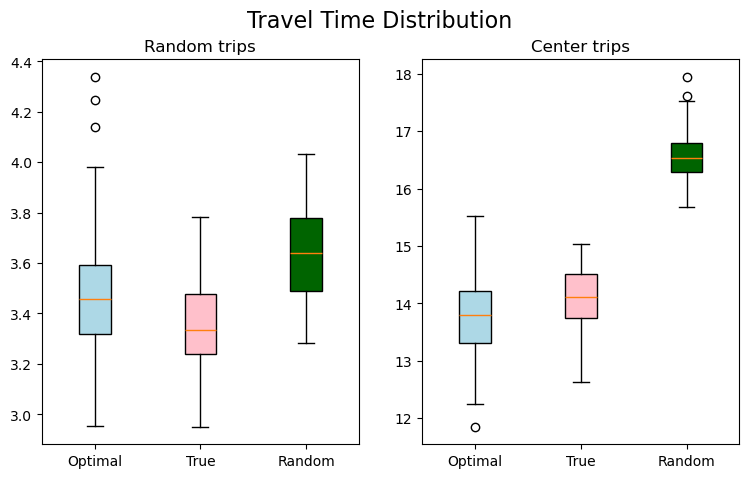

In [37]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(9, 5))

labels = ['Optimal', 'True', 'Random']

fig.suptitle('Travel Time Distribution', fontsize=16)

# rectangular box plot, normalized minutes instead of seconds
# for random trips
bplot1 = ax1.boxplot([oh_rt, th_rt, rh_rt],
                     vert=True,  
                     patch_artist=True,  
                     labels=labels)  
ax1.set_title('Random trips')

# for center trips
bplot2 = ax2.boxplot([oh_ct, th_ct, rh_ct],
                     vert=True,  
                     patch_artist=True, 
                     labels=labels) 
ax2.set_title('Center trips')

# fill with colors
colors = ['lightblue', 'pink', 'darkgreen']
for bplot in (bplot1, bplot2):
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)

fig.show()

From this plot, it's easy to see that with the optimal configuration the normalized time is higher than the other ones. Especially in the right plot the difference is more marked. <br>
Also, the variability of the optimal configuration is higher than the others.

Before address and interpret this results some analises must be perfomed.

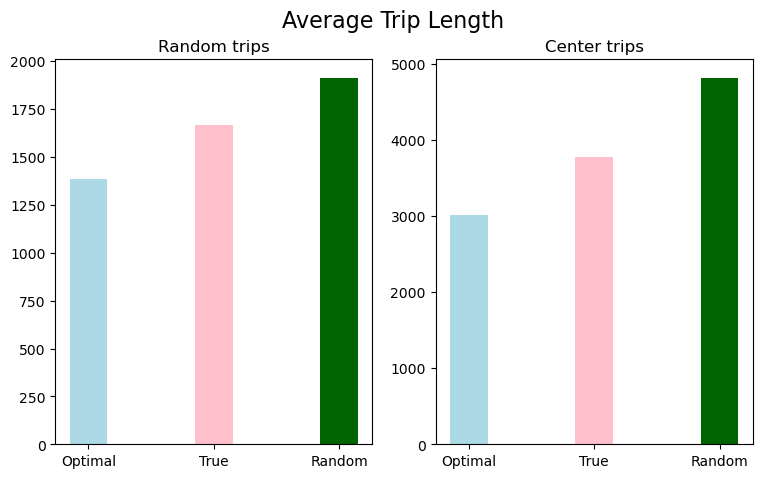

In [38]:
# Plot Bars
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(9, 5))
fig.suptitle('Average Trip Length', fontsize=16)

ax1.set_title('Random trips')
length_r = [np.mean(oh_lr), np.mean(th_lr), np.mean(rh_lr)]
barplot1 = ax1.bar(labels, length_r, color=colors, width=.3)

#for i, val in enumerate(data):
    #plt.text(i, val, float(val))
ax2.set_title('Center trips')
length_c = [np.mean(oh_lc), np.mean(th_lc), np.mean(rh_lc)]
barplot2 = ax2.bar(labels, length_c, color=colors, width=.3)

fig.show()

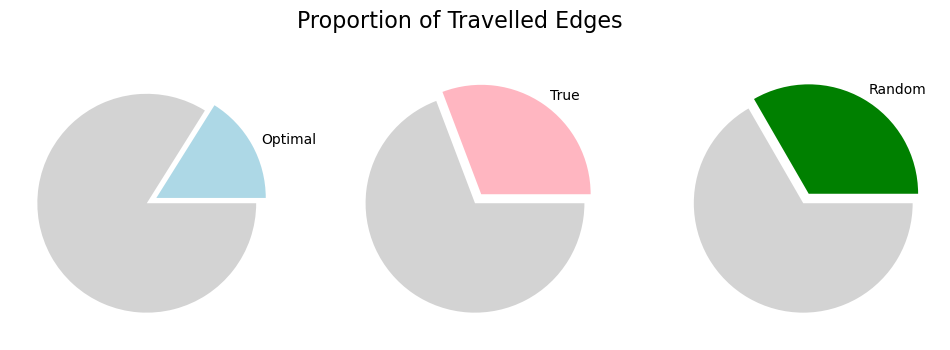

In [39]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

fig.suptitle('Proportion of Travelled Edges', fontsize=16)

ax1.pie([np.mean(oh_de)/len(net.getEdges()), 1-np.mean(oh_de)/len(net.getEdges())], 
        labels = ['Optimal',''], colors=['lightblue', 'lightgrey'], explode = [0.1, 0])

ax2.pie([np.mean(th_de)/len(net.getEdges()), 1-np.mean(th_de)/len(net.getEdges())], 
        labels = ['True',''], colors=['lightpink', 'lightgrey'], explode = [0.1, 0])

ax3.pie([np.mean(rh_de)/len(net.getEdges()), 1-np.mean(rh_de)/len(net.getEdges())], 
        labels = ['Random',''], colors=['green', 'lightgrey'], explode = [0.1, 0])

fig.show()

## Traffic Demand Proportional to the Flows

The final step was create a demand proportional to the real flows in Leuven. For this task, I needed a flow data frame describing <br>
the traffic model of Leuven. We already created one, derived from the traffic model of Leuven of the 2019*. In this version the file has <br>
the administrative zones and, for each combination, the aggregate flows of cars and of pedestrians between the zones.

From the flow data frame, I derived the proportion of flows for each OD pair, and use the fraction as weight during the generation of the flows, <br>
and the product between the proportion and the total outflow for the 7am time slot to generate a different number of vehicles for each flow.



*URL: https://storageaccount11111111.blob.core.windows.net/container1/Leuven/traffic_data/traffic_model_leuven_baseline_2019.gpkg

In [23]:
# open the flow data frame, for this task I considered only the car aggregate.
fdf = pd.read_csv('flussi_per_simulazione.csv')[['CODSEC_ORIG', 'CODSEC_DEST', 'flows_car_aggr']]
fdf.head()

,CODSEC_ORIG,CODSEC_DEST,flows_car_aggr
0,24062E774,24062B191,199.315802
1,24062A33-,24062B191,248.551733
2,24062F40-,24062B191,2.027756
3,24062C05-,24062B191,49.617696
4,24062D633,24062B191,18.481878


Variation of the uniform version. Consider the flow dataframe as distribution to extract the starting zone according to the frequencies <br>
and set the dimensions of the flows proportionally to the total extracted from the OD-Matrix 

In [24]:
def create_demand_proportional(hubs, fdf, n = 100):
    # city center definition
    city_center = (4.70110, 50.87993)
    x_c, y_c = net.convertLonLat2XY(city_center[0], city_center[1])
    candidates_center = net.getNeighboringEdges(x_c, y_c, r=25, includeJunctions=True)
    e_center = sorted(candidates_center, key = lambda x: x[1])[0][0].getID()

    i = 0
    # strings to save all the flows, differentiated by destination
    random_destination = ''
    center_destination = ''

    ## Generation phsa
    print('start generation phase...', end='')

    while i < n:
        #select a zone based on the flows
        start_zone = fdf.sample(1, weights=fdf['flows_car_aggr'])['CODSEC_ORIG'].values[0]
        #select one hub in the zone
        random_hub = hubs[hubs['CODSEC'] == start_zone].sample(1)
        #nearest neighbouring edge of the origin
        origin = random_hub['Edge'].values[0]

        #select one zone of its neighbor zone
        neighbors = zones_leuven[zones_leuven['CODSEC'] == start_zone]['adjacent'].values[0]
        dest_zone = np.random.choice(neighbors)

        size = (fdf[fdf['CODSEC_ORIG'] == start_zone]['flows_car_aggr'].values[0] * sof) / 2

        #destination point 1 -- random street in another zone
        destination = road_net[road_net['CODSEC'] == dest_zone].sample(1)['id'].values[0]
        random_destination += '<flow id = "r'+str(i)+'" begin="0" end="700" departLane="random" number="'+str(int(size))+'" from = "'+origin+'" to = "'+destination+'" type="type1"></flow> \n'

        #destination point2 -- city center
        center_destination += '<flow id = "c'+str(i)+'" begin="0" end="700" departLane="random" number="'+str(int(size))+'" from = "'+origin+'" to = "'+e_center+'" type="type1"></flow> \n'
        
        i +=1

    ## end generation phase
    print('end')

    #writing phase
    print('start writing file...', end='')
    # write the file
    f = open("Sumo/proportional_traffic_demand.xml", "w")
    #first row, currently onlt one type of vehicles
    f.write('<?xml version="1.0" encoding="UTF-8"?> <routes> <vType id="type1" length="5.00" maxSpeed="70.00" accel="2.6" decel="4.5" sigma="0.5" /> \n')
    #add trips
    f.write(random_destination)
    f.write(center_destination)
    f.write('</routes>')
    #end writing phase
    f.close()
    print('end')

### Duarouter

In [25]:
#same command, change the configuration file

command_str = "duarouter --route-files Sumo/proportional_traffic_demand.xml -n Sumo/osm.net.xml " +\
                " --weights.random-factor 25 "+\
                "-o Sumo/proportional_traffic_demand.rou.xml --repair true"

### SUMO

In [26]:
# same command, change configuration file

sumo_cmd = [sumo_binary, "-c", os.getcwd()+'/Sumo/proportional_config_duarouter.sumocfg', '-W', 'true', '--time-to-teleport', '5', '--no-step-log',
            '-v', 'false', '-t', 'false', '--vehroute-output', 'Sumo/fulloutput.xml', '--vehroute-output.route-length', 'true']

NameError: name 'sumo_binary' is not defined

In [35]:
# Main loop 
# generate a traffic demand, call duarouter, run multiple simulations. Repeat the process n times and 
# compute the averaged results.
# @input: hubs, geodataframe with the hub configuration
# @input: n, number of repetition
# @output: random_average_time, average time, between all the simulations, starting from a random hub to exit from its neighborhood
# @output: center_average_time, average time, between all the simulations from a random hub to reach the city center

def main_loop(hubs, fdf, n = 100):

    center_trips_avg = []
    random_trips_avg = []
    distinct_roads_avg = []
    length_random_avg = []
    length_center_avg = []

    i = 0
    while i < n:

        # create random traffic demand and write the file
        create_demand_proportional(hubs, fdf)

        # duarouter to complete the trips
        # due to the randomization, some configuration result incorrect. This problem
        # affects duarouter routing task and invalidates the result (the variance was much higher), I decided to keep track
        # only of the correct configuration, the problem needs to be investigated
        p = subprocess.Popen(command_str, shell=True, stdout=subprocess.PIPE, 
                                        stderr=subprocess.STDOUT)
        r = p.wait()

        # if an error occurs, restart
        if r != 0:
            continue
        
        #otherwise start the simulation
        print('-------------')
        print('iteration ', i+1)
        # start a simulation
        print('start simulation...')
        traci.start(sumo_cmd)

        print('    Starting time: 0')
        while traci.simulation.getTime() < 700 or len(traci.vehicle.getIDList()) > 0 :
            traci.simulationStep()

        print('    Ending time: ', traci.simulation.getTime())
        traci.close()
        print('end')


        with open('Sumo/fulloutput.xml', 'r') as f:
            data = f.read()

        random_trips, center_trips, distinct_roads, length_random, length_center = get_output(data)
        
        random_trips_avg.append(random_trips)
        center_trips_avg.append(center_trips)
        distinct_roads_avg.append(distinct_roads)
        length_random_avg.append(length_random)
        length_center_avg.append(length_center)


    return random_trips_avg, center_trips_avg, distinct_roads_avg, length_random_avg, length_center_avg

### Simulations

Then, I created different slice of the fdf to obtain correct results. Since different configuation of hubs cover different zones, <br>
it's possible to extract starting zones where no hubs were present. I simply restricted my dataframe to the zones covered by the configuration.

In [36]:
# starting point must have and hub
no_flow = []

for idx, row in fdf.iterrows():
    hub_list = hubs[hubs['CODSEC'] == row['CODSEC_ORIG']]
    if len(hub_list) == 0:
        no_flow.append(idx)

th_fdf = fdf.drop(no_flow, axis = 0)

In [37]:
# get the proportion according to the sliced dataframe
sums = th_fdf[['flows_car_aggr', 'flows_pae_aggr']].sum(axis=0)
th_fdf['flows_car_aggr'] = th_fdf['flows_car_aggr']/sums['flows_car_aggr']
th_fdf['flows_pae_aggr'] = th_fdf['flows_pae_aggr']/sums['flows_pae_aggr']

In [38]:
th_rt, th_ct, th_de, th_lr, th_lc =  main_loop(hubs, th_fdf)

-------------
iteration  1
start generation phase...end
start writing file...end
start duarouter...end
start simulation...
 Retrying in 1 seconds
    Starting time: 0
    Ending time:  861.0
end
-------------
iteration  2
start generation phase...end
start writing file...end
start duarouter...end
start simulation...
 Retrying in 1 seconds
    Starting time: 0
    Ending time:  4046.0
end
-------------
iteration  3
start generation phase...end
start writing file...end
start duarouter...end
start simulation...
 Retrying in 1 seconds
    Starting time: 0
    Ending time:  815.0
end
-------------
iteration  4
start generation phase...end
start writing file...end
start duarouter...end
start simulation...
 Retrying in 1 seconds
    Starting time: 0
    Ending time:  4536.0
end


KeyboardInterrupt: 

In [ ]:
np.random.seed()
r_hubs = road_net.sample(len(hubs), replace= True)
r_hubs.columns = ['Edge', 'geometry', 'CODSEC']

In [ ]:
# starting point must have and hub
no_flow = []

for idx, row in fdf.iterrows():
    hub_list = r_hubs[r_hubs['CODSEC'] == row['CODSEC_ORIG']]
    if len(hub_list) == 0:
        no_flow.append(idx)

rh_fdf = fdf.drop(no_flow, axis = 0)

In [ ]:
sums = rh_fdf[['flows_car_aggr', 'flows_pae_aggr']].sum(axis=0)
rh_fdf['flows_car_aggr'] = rh_fdf['flows_car_aggr']/sums['flows_car_aggr']
rh_fdf['flows_pae_aggr'] = rh_fdf['flows_pae_aggr']/sums['flows_pae_aggr']

In [ ]:
rh_rt, rh_ct, rh_de, rh_lr, rh_lc = main_loop(r_hubs, rh_fdf)

-------------
iteration  1
start generation phase...end
start writing file...end
start duarouter...end
start simulation...
 Retrying in 1 seconds
    Starting time: 0
    Ending time:  4142.0
end
-------------
iteration  2
start generation phase...end
start writing file...end
start duarouter...end
start simulation...
 Retrying in 1 seconds
    Starting time: 0
    Ending time:  4154.0
end
-------------
iteration  3
start generation phase...end
start writing file...end
start duarouter...end
start simulation...
 Retrying in 1 seconds
    Starting time: 0
    Ending time:  843.0
end
-------------
iteration  4
start generation phase...end
start writing file...end
start duarouter...end
start simulation...
 Retrying in 1 seconds
    Starting time: 0
    Ending time:  4218.0
end
-------------
iteration  5
start generation phase...end
start writing file...end
start duarouter...end
start simulation...
 Retrying in 1 seconds
    Starting time: 0
    Ending time:  1044.0
end
-------------
iterati

In [ ]:
# starting point must have and hub
no_flow = []

for idx, row in fdf.iterrows():
    hub_list = opt_hubs[opt_hubs['CODSEC'] == row['CODSEC_ORIG']]
    if len(hub_list) == 0:
        no_flow.append(idx)

oh_fdf = fdf.drop(no_flow, axis = 0)

In [ ]:
sums = oh_fdf[['flows_car_aggr', 'flows_pae_aggr']].sum(axis=0)
oh_fdf['flows_car_aggr'] = oh_fdf['flows_car_aggr']/sums['flows_car_aggr']
oh_fdf['flows_pae_aggr'] = oh_fdf['flows_pae_aggr']/sums['flows_pae_aggr']

In [ ]:
oh_rt, oh_ct, oh_de, oh_lr, oh_lc = main_loop(opt_hubs, oh_fdf)

-------------
iteration  1
start generation phase...end
start writing file...end
start duarouter...end
start simulation...
 Retrying in 1 seconds
    Starting time: 0
    Ending time:  804.0
end
-------------
iteration  2
start generation phase...end
start writing file...end
start duarouter...end
start simulation...
 Retrying in 1 seconds
    Starting time: 0
    Ending time:  858.0
end
-------------
iteration  3
start generation phase...end
start writing file...end
start duarouter...end
start simulation...
 Retrying in 1 seconds
    Starting time: 0
    Ending time:  4112.0
end
-------------
iteration  4
start generation phase...end
start writing file...end
start duarouter...end
start simulation...
 Retrying in 1 seconds
    Starting time: 0
    Ending time:  853.0
end
-------------
iteration  5
start generation phase...end
start writing file...end
start duarouter...end
start simulation...
 Retrying in 1 seconds
    Starting time: 0
    Ending time:  4282.0
end
-------------
iteration

In [ ]:
pd.DataFrame({'rt': th_rt, 'ct':th_ct, 'de':th_de, 'lr': th_lr,'lc': th_lc}).to_csv('proportional_trueHubs')
pd.DataFrame({'rt': rh_rt, 'ct':rh_ct, 'de':rh_de, 'lr': rh_lr,'lc': rh_lc}).to_csv('proportional_randHubs')
pd.DataFrame({'rt': oh_rt, 'ct':oh_ct, 'de':oh_de, 'lr': oh_lr,'lc': oh_lc}).to_csv('proportional_optHubs')

### Results

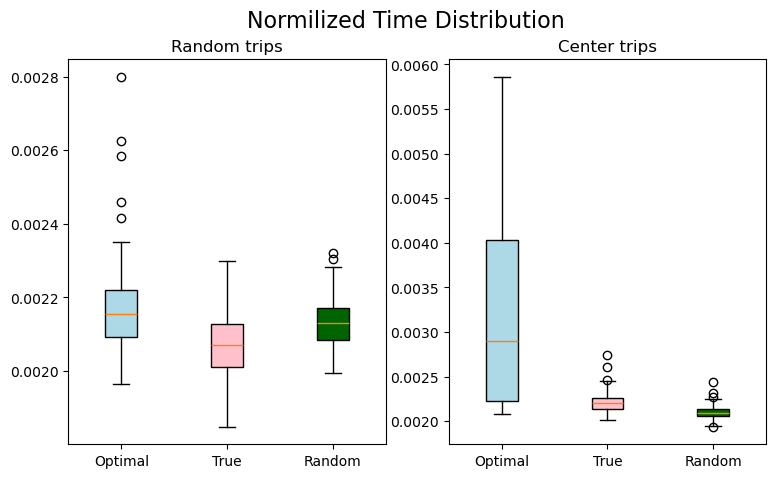

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(9, 5))

labels = ['Optimal', 'True', 'Random']

fig.suptitle('Normilized Time Distribution', fontsize=16)

# rectangular box plot, normalized minutes instead of seconds
# for random trips
bplot1 = ax1.boxplot([oh_rt, th_rt, rh_rt],
                     vert=True,  
                     patch_artist=True,  
                     labels=labels)  
ax1.set_title('Random trips')

# for center trips
bplot2 = ax2.boxplot([oh_ct, th_ct, rh_ct],
                     vert=True,  
                     patch_artist=True, 
                     labels=labels) 
ax2.set_title('Center trips')

# fill with colors
colors = ['lightblue', 'pink', 'darkgreen']
for bplot in (bplot1, bplot2):
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)

fig.show()

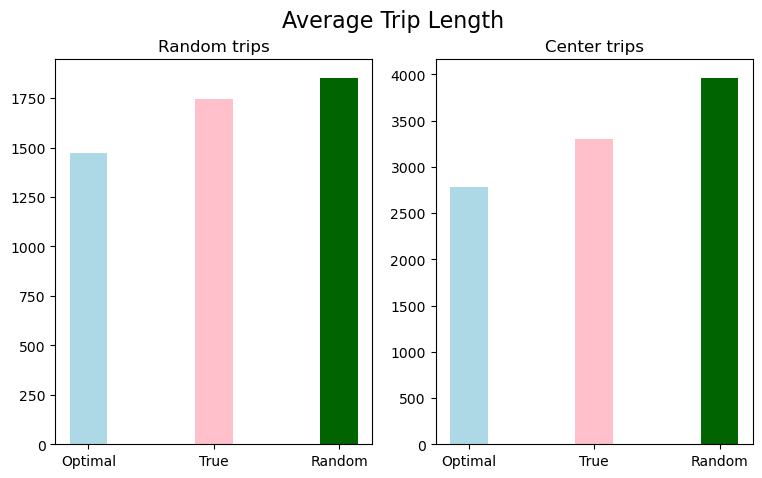

In [ ]:
# Plot Bars
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(9, 5))
fig.suptitle('Average Trip Length', fontsize=16)

ax1.set_title('Random trips')
length_r = [np.mean(oh_lr), np.mean(th_lr), np.mean(rh_lr)]
barplot1 = ax1.bar(labels, length_r, color=colors, width=.3)

#for i, val in enumerate(data):
    #plt.text(i, val, float(val))
ax2.set_title('Center trips')
length_c = [np.mean(oh_lc), np.mean(th_lc), np.mean(rh_lc)]
barplot2 = ax2.bar(labels, length_c, color=colors, width=.3)

fig.show()

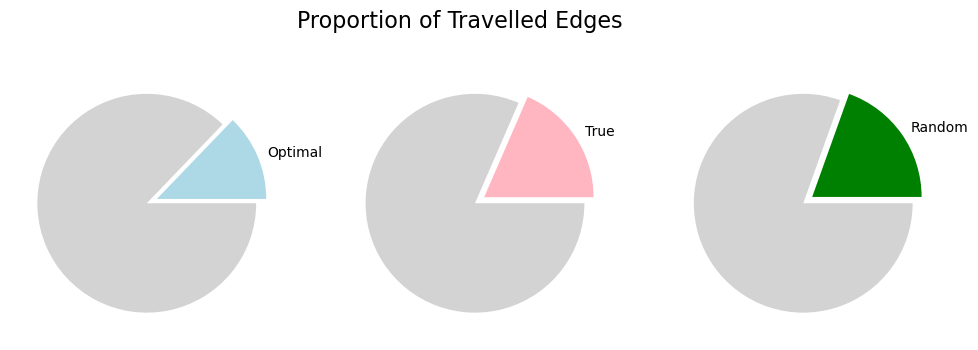

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

fig.suptitle('Proportion of Travelled Edges', fontsize=16)

ax1.pie([np.mean(oh_de)/len(net.getEdges()), 1-np.mean(oh_de)/len(net.getEdges())], 
        labels = ['Optimal',''], colors=['lightblue', 'lightgrey'], explode = [0.1, 0])

ax2.pie([np.mean(th_de)/len(net.getEdges()), 1-np.mean(th_de)/len(net.getEdges())], 
        labels = ['True',''], colors=['lightpink', 'lightgrey'], explode = [0.1, 0])

ax3.pie([np.mean(rh_de)/len(net.getEdges()), 1-np.mean(rh_de)/len(net.getEdges())], 
        labels = ['Random',''], colors=['green', 'lightgrey'], explode = [0.1, 0])

fig.show()

## Conclusions